# Date Leakage and Dependent Data

In [8]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

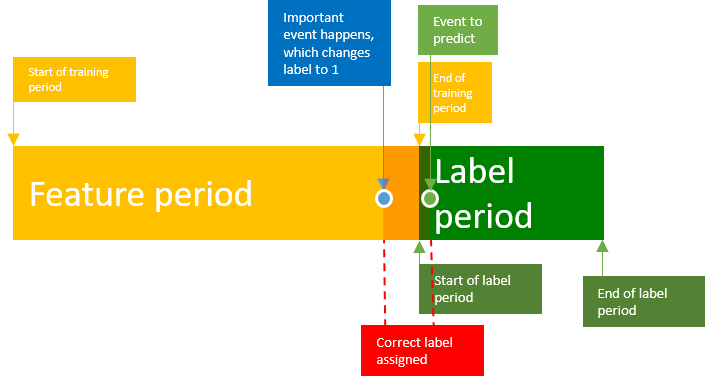

In [9]:
Image("../images/data-leakage explanation.png")
# <img alt="" caption="how data leakage might happen" 
# id="data_leakage" src="../images/data-leakage explanation.png" width="640" height="640">
# image taken form [here](https://towardsdatascience.com/how-data-leakage-affects-machine-learning-models-in-practice-f448be6080d0)

# Sources of data leakage
### train data contains features that are not available in production
e.g., the row-number contains information about the target: first come the negative examples, the positive cases were then simply inserted underneath.  

### future data somehow slipped into the training set
e.g. Giba's property:
[taken from kaggle](https://www.kaggle.com/c/santander-value-prediction-challenge/discussion/61329)<br>

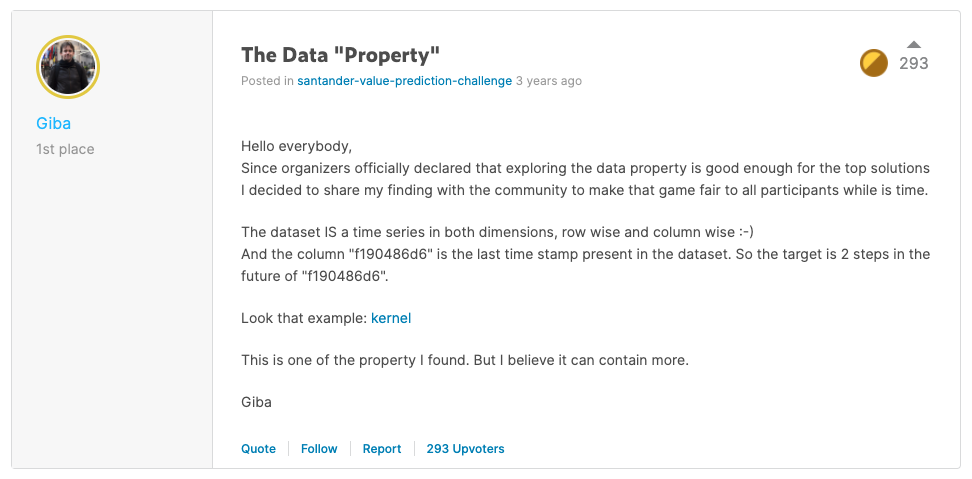

In [10]:
Image("../images/Giba_santander.png")
# <img alt="" caption="how data leakage might happen" 
# id="data_leakage" src="../images/Giba_santander.png" width="640" height="640"><br>

and here is the mentioned data-structure:<br>
[this kernel exploits the leakage](https://www.kaggle.com/rebeccaysteboe/giba-s-property-extended-result)

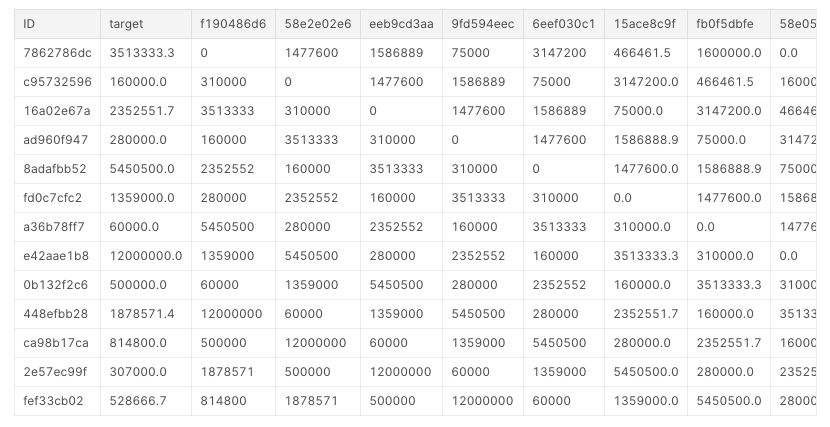

In [11]:
Image("../images/Gibas_data_structure.png") 
# <img alt="" caption="how data leakage might happen" 
# id="data_leakage" src="../images/Gibas_data_structure.png" width="640" height="640"><br>

### there is one feature that interacts with the target
taken from [Breast Cancer Identification: KDD CUP Winner’s Report](http://kdd.org/exploration_files/KDDCup08-P1.pdf)<br>
Distribution of malignant (black) and benign (gray) candidates depending on patient ID on the X-axis in log scale.

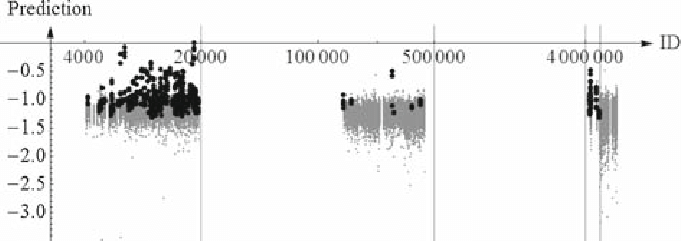

In [12]:
Image("../images/Distribution-of-malignant-black-and-benign-gray-candidates-depending-on-patient-ID-on.png")
# <img alt="" caption="how data leakage might happen" 
# id="data_leakage" src="../images/Distribution-of-malignant-black-and-benign-gray-candidates-depending-on-patient-ID-on.png" width="640" height="640"><br>


### Some more cases where we have data leakage: 
   - Customer advisor has a long call with customer and finally sells the product that is shipped only two weeks later. Variables 'last advisory contact' and 'length of call' certainly anticipate the product sale. When an algorithm learns to predict product propensity based on 'last advisor contact' it will ultimately suggest customers to the advisors for whom the advisor has already closed the deal.
   - Train and test data is normalized with common sample statistics belonging to the whole data set
        * target encoding is dangerous: we will talk about it later on
        * stacking is dangerous: we will discuss this topic as well

### credit card applications
[example taken from here](https://www.kaggle.com/dansbecker/data-leakage)
 - card: Dummy variable, 1 if application for credit card accepted, 0 if not
 - reports: Number of major derogatory reports
 - age: Age n years plus twelfths of a year
 - income: Yearly income (divided by 10,000)
 - share: Ratio of monthly credit card expenditure to yearly income
 - expenditure: Average monthly credit card expenditure
 - owner: 1 if owns their home, 0 if rent
 - selfempl: 1 if self employed, 0 if not.
 - dependents: 1 + number of dependents
 - months: Months living at current address
 - majorcards: Number of major credit cards held
 - active: Number of active credit accounts


In [28]:
import pandas as pd

url = 'https://raw.githubusercontent.com/YoshiKitaguchi/Credit-card-verification-project/master/AER_credit_card_data.csv'
df = pd.read_csv(url, error_bad_lines=False, true_values = ['yes'], false_values = ['no'])
print(df.head())

   card  reports       age  income     share  expenditure  owner  selfemp  \
0  True        0  37.66667  4.5200  0.033270   124.983300   True    False   
1  True        0  33.25000  2.4200  0.005217     9.854167  False    False   
2  True        0  33.66667  4.5000  0.004156    15.000000   True    False   
3  True        0  30.50000  2.5400  0.065214   137.869200  False    False   
4  True        0  32.16667  9.7867  0.067051   546.503300   True    False   

   dependents  months  majorcards  active  
0           3      54           1      12  
1           3      34           1      13  
2           4      58           1       5  
3           0      25           1       7  
4           2      64           1       5  


In [14]:
!pip install lightgbm imblearn

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
import lightgbm

y = df['card']
X = df.drop('card', axis=1)

In [16]:
model = lightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1, 
                                n_estimators=500, subsample_for_bin=20000, objective='binary', 
                                subsample=1.0, subsample_freq=0, colsample_bytree=1.0, 
                                n_jobs=- 1, silent=True, importance_type='split',
                                is_unbalance = False, scale_pos_weight = 1.0)
model_pipe = make_pipeline(model)
cv_scores = cross_val_score(model_pipe, X, y, scoring='accuracy')
print(np.mean(cv_scores))

0.9765065099665862


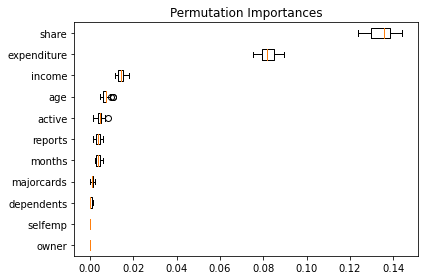

In [20]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
model.fit(X, y)
result = permutation_importance(model, X, y,
        n_repeats=30,
        random_state=0)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

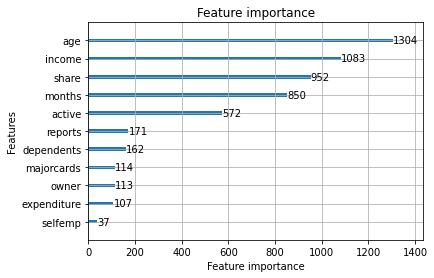

In [9]:
model.fit(X, y)
lightgbm.plot_importance(model)

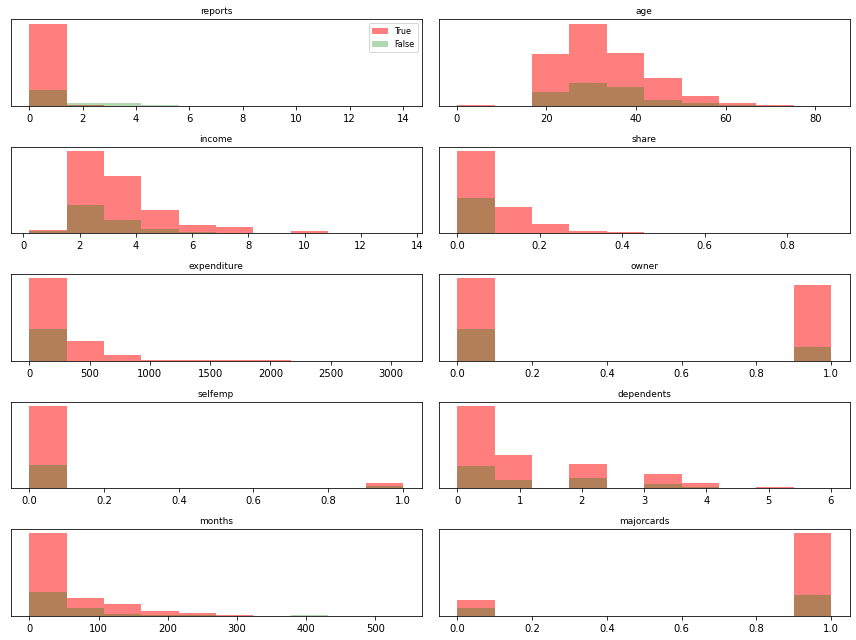

In [10]:
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore')
fig,axes =plt.subplots(5,2, figsize=(12, 9)) # 3 columns each containing 10 figures, total 30 features
# malignant=cancer.data[cancer.target==0] # define malignant
# benign=cancer.data[cancer.target==1] # define benign
ax=axes.ravel()# flat axes with numpy ravel
for i, col in enumerate(X.columns.tolist()[0:10]):
  _,bins=np.histogram(X[col])
  ax[i].hist(X.loc[y == True, col],bins=bins,color='r',alpha=.5)
  ax[i].hist(X.loc[y == False, col],bins=bins,color='g',alpha=0.3)
  ax[i].set_title(col, fontsize=9)
  ax[i].axes.get_xaxis().set_visible(True) # the x-axis co-ordinates are not so useful, as we just want to look how well separated the histograms are
  ax[i].set_yticks(())
ax[0].legend(['True','False'],loc='best',fontsize=8)    
plt.tight_layout()# let's make good plots
plt.show() 



In [11]:
display(X.loc[y == True, 'expenditure'].mean(), X.loc[y == False, 'expenditure'].mean())

238.60242068103616

0.0

In [12]:
display(X.loc[y == True, 'share'].mean(), X.loc[y == False, 'share'].mean())

0.08848152972453567

0.0004767954841216091

In [13]:
!pip install dtreeviz

In [14]:
from sklearn import tree
from dtreeviz.trees import *
import matplotlib.pyplot as plt
classifier = tree.DecisionTreeClassifier(max_depth=3)  # limit depth of tree
classifier.fit(X, y)


viz = dtreeviz(classifier, 
               X.values,
               y.values, 
               target_name='credit-card application',
               feature_names=X.columns.tolist(),
               class_names = ['not_accepted', 'accepted']
              )  

viz.save("decision_tree.svg") 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


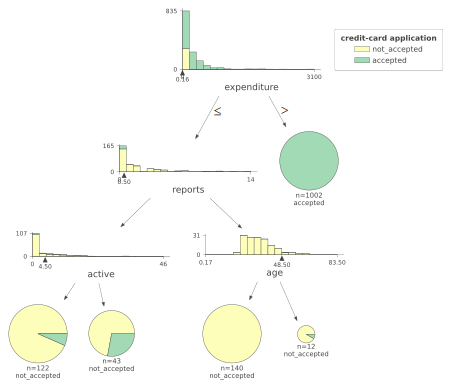

In [15]:
# from IPython.core.display import HTML
# HTML(''' <' img src='decision_tree.svg' / > ''')
import IPython
#IPython.display.SVG('decision_tree.svg')

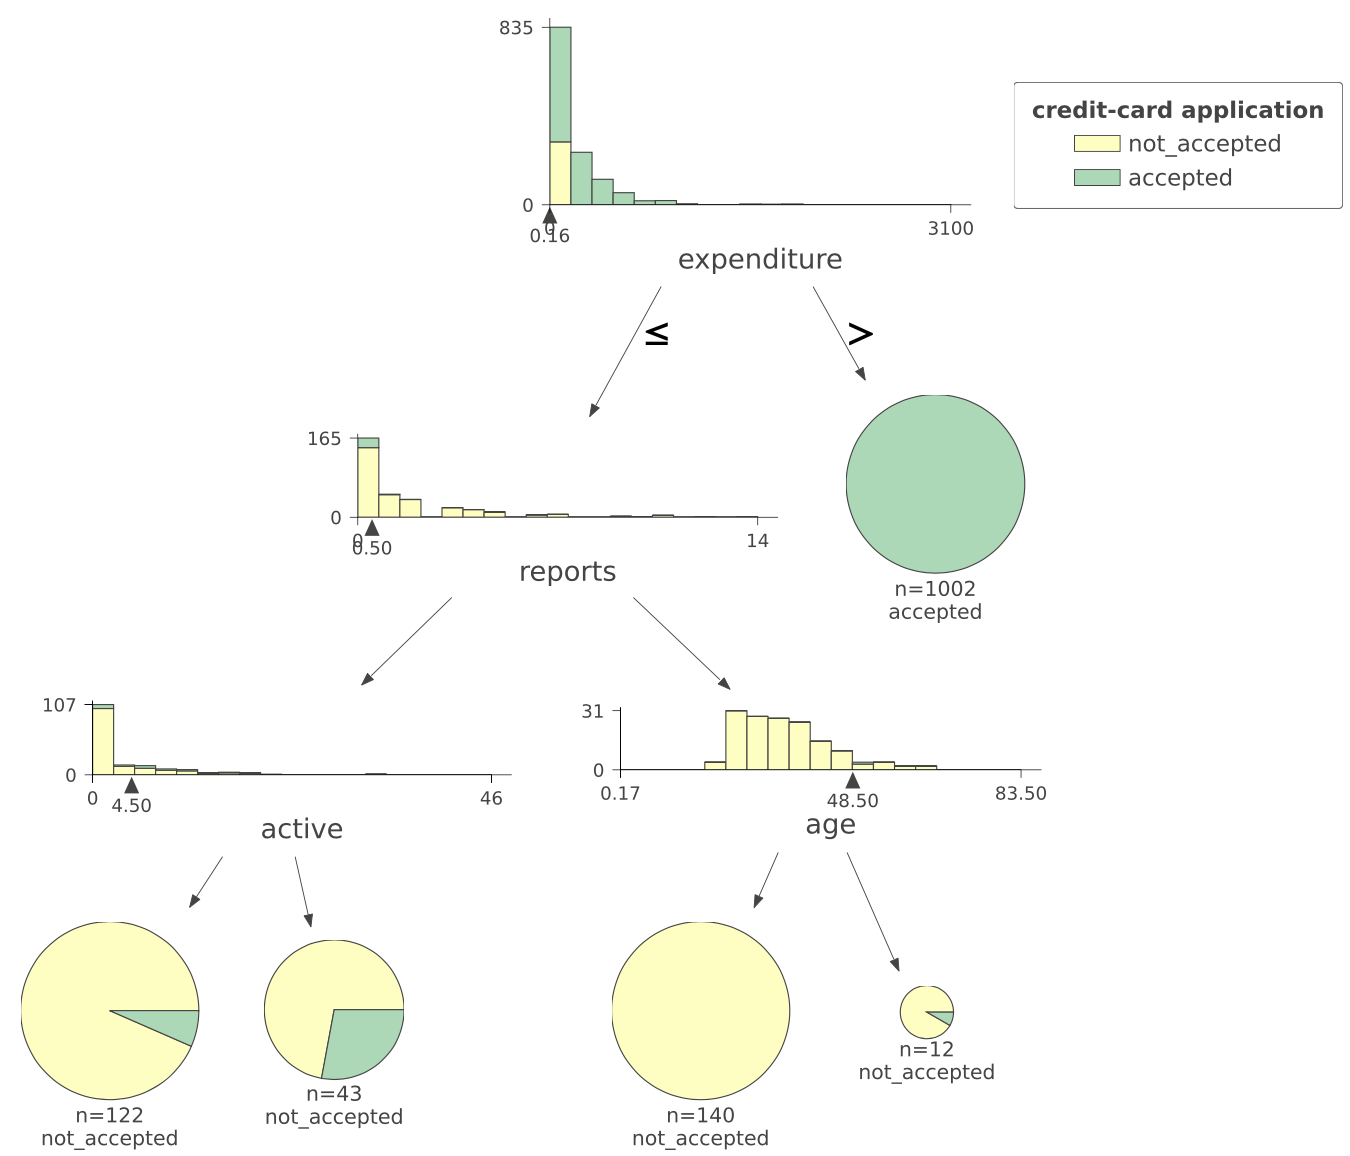

In [3]:
# from IPython.display import SVG, display
# from IPython.display import display, Markdown
# display(Markdown('![figure](decision_tree.svg)'))
# warnings.filterwarnings('ignore')
# viz
# warnings.filterwarnings('once')
Image("decision_tree.png")

## Solution:
Obviously, 
  - share: Ratio of monthly credit card expenditure to yearly income
  - expenditure: Average monthly credit card expenditure

are features that suppose the applicant was granted a credit card.

# Dependency between data-samples

Training Machine Learning Algorithms works best, when we have many independent data samples in the training data. Dependent data arises when:

  - we take repeatedly measures from the same individual (the trained algorithms will not generalize to other individuals)
  - we take samples only from one bank (the socia-demographic structure of GKB's customers might be differentfrom that of BCG's customers - as a result the algorithm will badly generalize)
  - 



Here, we are dealing with highly imbalanced data. One way to cope with it, is to replicate some examples of the minority-class (we will have a closer look at this problem in an extra notebook). By replicating some observations, the samples are not independent anymore. 

## First contact with Pipeline

```Pipeline``` from sklearn is a tool that bundles different preprocessing steps. This is especially convenient when we are doing cross-validation; Without ```Pipeline```we would have to code the different preprocessing steps as well as the cross-validation within a ```for-loop```.<br>
The next graphic is taken from [here](https://iaml.it/blog/optimizing-sklearn-pipelines)

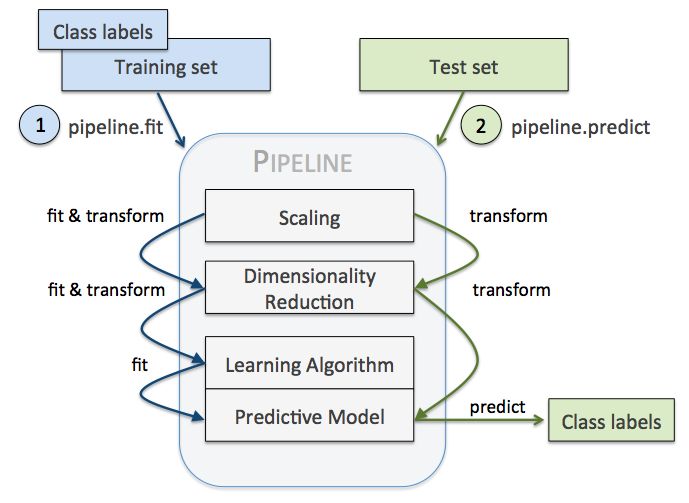

In [17]:
Image("../images/pipeline_diagram.png")

In [62]:
subsample_cc = pd.read_csv("../data/creditcard_subsampled.csv")
subsample_cc.head()

,index,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [23]:
pd.crosstab(subsample_cc.Class.astype(str) + "_true", pd.Series(np.zeros_like(subsample_cc.Class)).astype(str) + "_Actual")

col_0,0_Actual
Class,
0_true,100000
1_true,492


One strategy in these cases is oversampling of the minority class:

In [24]:
import imblearn
from imblearn.over_sampling import SMOTE
y_train = subsample_cc.Class
X_train = subsample_cc.drop('Class', axis = 1)

# This is where we replicate some of the positive cases
X_train_ov, y_train_ov = SMOTE(sampling_strategy=0.03).fit_resample(X_train, y_train)
pd.crosstab(y_train_ov.astype(str) + "_true", pd.Series(np.zeros_like(y_train_ov)).astype(str) + "_Actual")

col_0,0_Actual
Class,
0_true,100000
1_true,3000


In [63]:
# from sklearn.utils import resample
# y_train = subsample_cc.Class
# X_train = subsample_cc.drop('Class', axis=1)
# upsample = resample(X_train.loc[y_train == True],
#              replace=True,
#              n_samples=1500 - sum(y_train),
#              random_state=42)
# X_train_ov = pd.concat([X_train, upsample], axis=0)
# y_train_ov = pd.concat([y_train, pd.Series(np.ones((1500-sum(y_train))))])
# pd.crosstab(y_train_ov.reset_index(drop=True).astype(str) + "_true", pd.Series(np.zeros_like(y_train_ov)).astype(str) + "_Actual")

col_0,0.0_Actual
row_0,
0.0_true,100000
1.0_true,1500


We take a gradient-boosting-classifier (more on this topic later)<br>
and compute the mean f1-score for the different folds:

In [64]:
from sklearn.metrics import f1_score, make_scorer
model = lightgbm.LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1, 
                                n_estimators=500, subsample_for_bin=20000, objective='binary', 
                                subsample=1.0, subsample_freq=0, colsample_bytree=1.0, 
                                n_jobs=- 1, silent=True, importance_type='split',
                                is_unbalance = False, scale_pos_weight = 1.0)
model_pipe = make_pipeline(model)
cv_scores = cross_val_score(model_pipe, X_train_ov, y_train_ov, scoring=make_scorer(f1_score, labels=[2]), cv = 2)
print(np.mean(cv_scores))

0.9828092562783878


what happens when we augment the number of cross-validation folds?<br>
 - we have more training-data in the folds we use for training
 - the probability that some of the replicated cases are in the training and in the test set is higher -> more data leakage

In [65]:
folds = 5
cv_scores = cross_val_score(model_pipe, X_train_ov, y_train_ov, scoring=make_scorer(f1_score, labels=[2]), cv = folds)
print(f"""f1-score for {folds}-fold cross-validation: {np.mean(cv_scores)}""")

folds = 10
cv_scores = cross_val_score(model_pipe, X_train_ov, y_train_ov, scoring=make_scorer(f1_score, labels=[2]), cv = folds)
print(f"""f1-score for {folds}-fold cross-validation: {np.mean(cv_scores)}""")

f1-score for 5-fold cross-validation: 0.9879242696875334
f1-score for 10-fold cross-validation: 0.9872838257834472


## the correct way to do it: oversample within each fold:
This is where ```Pipeline```shines

In [23]:
from imblearn.pipeline import Pipeline
ov_pipeline = Pipeline([
        ('sampling', SMOTE(sampling_strategy=0.03)),
        ('classification', model)
    ])
folds = 5
cv_scores = cross_val_score(ov_pipeline, X_train, y_train, scoring=make_scorer(f1_score, labels=[2]), cv=folds)

print(f"""f1-score for {folds}-fold cross-validation: {np.mean(cv_scores)}""")
folds = 10
cv_scores = cross_val_score(ov_pipeline, X_train, y_train, scoring=make_scorer(f1_score, labels=[2]), cv=folds)
print(f"""f1-score for {folds}-fold cross-validation: {np.mean(cv_scores)}""")

f1-score for 5-fold cross-validation: 0.788538141844491
f1-score for 10-fold cross-validation: 0.8614838865031157


Compare those results with the ones we obtained when we did first the up-sampling and then the cross-validation!

## Some more cases where we have dependent data
 - Repeatedly sampling data from the same individual:
     * Fraud: A fraudster commits many frauds that have a similiar pattern; For example for every fraud commited, the fraudster uses a different account of the same bank in Thailand. When doing cross-validation we have frauds related to the very bank in Thailand in the training set as well as in the test set. Hence, we will overestimate the capability of the trained classifier to generalize to new, unseen fraud cases. But it will be very efficient to detect this one fraudster with bank accounts in Thailand.
     * customer journey: to detect an event as soon as possible, data is sampled with different offsets before the event's occurence. When trying to predict an event we could be tempted to sample data from different points in time before the event. This data will always be very similar and is hence dependent. For example, medical health records are not changing very fast and blood pressure two months ago will be similar to that measured one month ago. Most bank accounts have a similar balance in a one months distance.
     * classifying websites: social media websites belong all to facebook. There are just not enough social media websites to learn something about them in the training set and generalize to other social media websites in the test set. 
 - Train and test data is normalized with common sample statistics belonging to the whole data set
     * target encoding is dangerous: we will talk about it later on
     * stacking is dangerous: we will discuss this topic as well
 - Sentence Classification: sentences belonging to the same document
     * customer churn: An angry customer sends frequent e-mails. All e-mails happen to have the same characteristics, e.g. instead of the *Umlaut* 'ü', the customer uses 'ue'. The algorithm might be tempted to learn that 'ue' is a special churn-characteristic. When half of the e-mails end up in the train set and the rest in the test set, we will overestimate the prediction accuracy of the learned algorithm.
     * When building a classifier to distinct medical publications from IT-related publications, it is important to have a representative sample of medical topics as well as tech-topics. When taking sentences from one document that is heavily Java related, the algorithm will struggle to generalize to the programming language Python. When the 'Java-sentences' are in the train set as well as in the test set, we will overestimate the algorithm's performance on new documents.
 - Diagnosis: patient records coming from the same hospital
     * Hospitals might have different specializations; When we want to predict diagnosis based on the doctors' reports, cancer cases from a clinic specialized in cancer treatments might have higher similarity to each other than cancer cases coming from a orthopaedic hospital. When the reports of the specialized clinic end up in the train set as well as in the test set, we will overestimate the algorithm's capability to correctly classifiy the diagnosis 'cancer'. 
       

### recent article summarizing errors when predicting COVID:
Excerpts of the article [Hundreds of AI tools have been built to catch covid. None of them helped.](https://www.technologyreview.com/2021/07/30/1030329/machine-learning-ai-failed-covid-hospital-diagnosis-pandemic):<br>

"They looked at 415 published tools and, like Wynants and her colleagues, concluded that none were fit for clinical use."<br>

"Both teams found that researchers repeated the same basic errors in the way they trained or tested their tools."<br>

"Many of the problems that were uncovered are linked to the poor quality of the data that researchers used to develop their tools."<br>

 - __duplicates:__ "Driggs highlights the problem of what he calls Frankenstein data sets, which are spliced together from multiple sources and can contain duplicates."
 - __confounding variables:__ <br>
   * "Many unwittingly used a data set that contained chest scans of children who did not have covid as their examples of what non-covid cases looked like. But as a result, the AIs learned to identify kids, not covid."
   * "Because patients scanned while lying down were more likely to be seriously ill, the AI learned wrongly to predict serious covid risk from a person’s position."
 - __different sources:__ "In yet other cases, some AIs were found to be picking up on the text font that certain hospitals used to label the scans. As a result, fonts from hospitals with more serious caseloads became predictors of covid risk."
 - __human labeling error:__ "It would be much better to label a medical scan with the result of a PCR test rather than one doctor’s opinion, says Driggs."
 <br>
 
### How to fix it?

 - "Better data would help, but in times of crisis that’s a big ask."<br>
 - “'Until we buy into the idea that we need to sort out the unsexy problems before the sexy ones, we’re doomed to repeat the same mistakes,' says Mateen."
<br>

Original articles:<br>
[Wynants et al., 2020. Prediction models for diagnosis and prognosis of covid-19: systematic review and critical appraisal](https://www.bmj.com/content/369/bmj.m1328)<br>
[Roberts et al., 2021. Common pitfalls and recommendations for using machine learning to detect and prognosticate for COVID-19 using chest radiographs and CT scans](https://www.nature.com/articles/s42256-021-00307-0)




### Data leakage Literature

* [examples of data leakage in competitions: start on page 19](https://static1.squarespace.com/static/5a4c161cfe54ef45b17aa18e/t/5ab4013b88251b7b684c6025/1521746286132/week2-part2.pdf)<br>
* [alternative to the text above here is the video](https://www.coursera.org/lecture/competitive-data-science/basic-data-leaks-5w9Gy)<br>
* [Medical data mining: insights from winning two competitions](https://www.prem-melville.com/publications/medical-mining-dmkd09.pdf)

__important__: if you're not allowed to read any more 'towardsdatascience' article or 'medium' articles -- just remove the cookies for the page (inspect -> applications -> cookies) and reload the page afterwards.<br>
* [data leakage when tuning hyper-parameters](https://towardsdatascience.com/data-leakage-with-hyper-parameter-tuning-c57ba2006046)